# 3. 사이킷런을 타고 떠나는 머신러닝 분류 모델 투어

In [1]:
from rich import pretty
pretty.install()

## 3.1 분류 알고리즘 선택

알고리즘을 훈련하기 위한 다섯 가지 주요 단계

1. 특성을 선택하고 훈련 샘플을 모음
2. 성능 지표를 선택
3. 분류 모델과 최적화 알고리즘을 선택
4. 모델의 성능을 평가
5. 알고리즘을 튜닝


## 3.2 사이킷런 첫걸음: 퍼셉트론 훈련


In [2]:
# data loading
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


In [3]:
# train test splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

In [4]:
print('y의 레이블 카운트: ', np.bincount(y))

y의 레이블 카운트:  [50 50 50]


In [5]:
print('y_train의 레이블 카운트: ', np.bincount(y_train))

y_train의 레이블 카운트:  [35 35 35]


In [6]:
print('y_test의 레이블 카운트: ', np.bincount(y_test))

y_test의 레이블 카운트:  [15 15 15]


In [7]:
# 표준화
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [8]:
# Perceptron training
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [9]:
# 오분류
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


In [10]:
# Accuracy
from sklearn.metrics import accuracy_score
print('정확도: %.3f' % accuracy_score(y_test, y_pred))

정확도: 0.978


In [11]:
print('정확도: %.3f' % ppn.score(X_test_std, y_test))

정확도: 0.978


In [12]:
# module loading
import matplotlib.pyplot as plt
import plot_decision_regions as pltreg

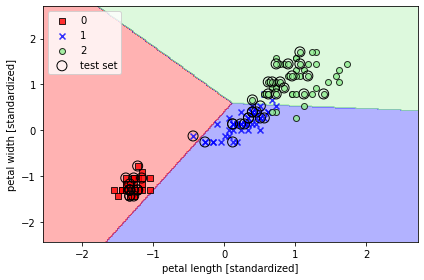

In [13]:
# 퍼셉트론 모델의 결정 경계 그리기
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
pltreg.plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3.3 로지스틱 회귀를 사용한 클래스 확률 모델링

### 3.3.1 로지스틱 회귀의 이해와 조건부 확률

구현하기 매우 쉽고 선형적으로 구분되는 클래스에 뛰어난 성능  

**소프트맥스 회귀**: https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L08_logistic_slides.pdf 참고
  - GOTO: 핸즈온 머신러닝 2판, Chapter 4.

$$\phi(z)=\frac{1}{1+e^{-z}}$$

*Example*: 어떤 붓꽃 샘플이 $\phi(z)=P(y=1|\mathbb{x;\,w})=0.8$이면, 이 샘플은 Iris-versicolor일 확률이 80%

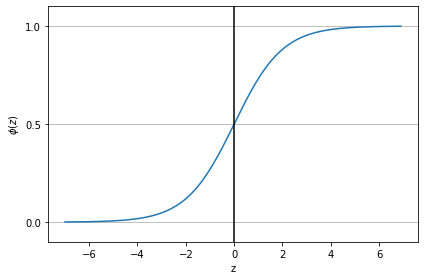

In [14]:
# 시그모이드 함수 그리기
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y 축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### 3.3.2 로지스틱 비용 함수의 가중치 학습

제곱 오차항 비용 함수:  
$$J(\mathbb{w})=\frac{1}{2}\sum_i(y^{(i)}-\phi(z^{(i)}))^2$$

로지스틱 회귀의 비용 함수:  
데이터셋에 있는 각 샘플이 서로 독립적이라고 가정, 최대화하려는 가능도 (likelihood) $L$을 정의  

$$L(w)=P(\mathbb{y}|\mathbb{x;w})=\prod_{i=1}^nP(y^{(i)}|\mathbb{x}^{(i)}\mathbb{;w}) \\
=\prod_{i=1}^n(\phi(z^{(i)}))^{y^{(i)}}(1-\phi(z^{(i)}))^{1-y^{(i)}}$$

이 공식의 (자연) 로그를 최대화 - 로그 가능도 함수  

$$l(w)=\log{L(w)}=\sum_{i=1}^n\left[y^{(i)}\log(\phi(z^{(i)}))+(1-y^{(i)})\log(1-\phi(z^{(i)}))\right]$$

1) 가능도가 매우 작을 때 일어나는 수치 상의 언더플로를 방지
2) 계수의 곱을 계수의 합으로 바꿀 수 있다. - 도함수를 구하기 쉽다.


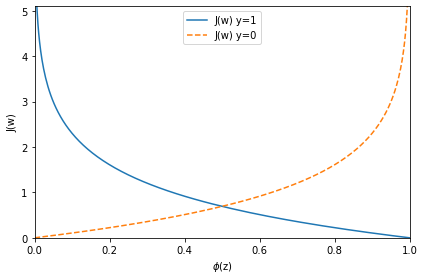

In [15]:
# 샘플이 하나인 경우 분류 비용 계산
def cost_1(z):
    return -np.log(sigmoid(z))
def cost_0(z):
    return -np.log(1-sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### 3.3.3 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

최소화해야 할 비용 함수 (from above section: 3.3.2)  
logisticregressiongd.py에 LogisticRegressionGD class 구현  
Iris-setosa, versicolor 붓꽃으로 로지스틱 회귀 구현 확인 

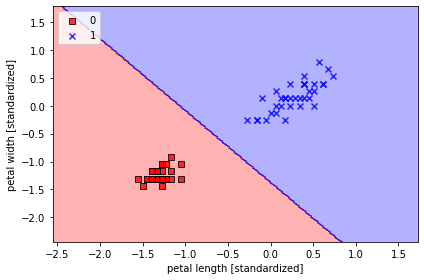

In [16]:
from logisticregressiongd import LogisticRegressionGD

X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

pltreg.plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/03_05.png', dpi=300)
plt.show()

### 3.3.4 사이킷런을 사용하여 로지스틱 회귀 모델 훈련

skearn.linear_model.LogisticRegression의 fit 메소드  


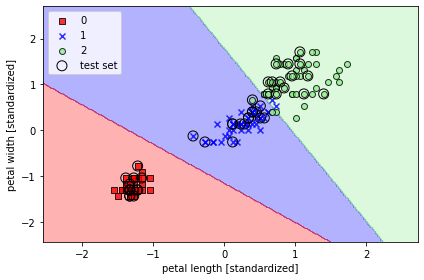

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
pltreg.plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
# 클래스 소속 확률은?
lr.predict_proba(X_test_std[:3, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17]])

In [19]:
# 행에서 가장 큰 값의 열이 예측 클래스 레이블
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [20]:
# 사이킷런의 메소드를 그대로 이용하여
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [21]:
# WARN: 샘플 하나의 클래스 레이블을 예측할 때
# TODO: 하나의 행을 2차원 포맷으로 먼저 변경해야 한다.
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### 3.3.5 규제를 사용하여 과대적합 피하기

규제 (regularization)은 공선성 (collinearity)을 다루거나, 잡음을 제거하여 과대적합을 방지할 수 있는 방법  
과도한 파라미터 값을 제한하기 위해 추가적인 정보 (편향)을 주입하는 개념  
가장 널리 사용하는 **L2 규제**:  
$$\frac{\lambda}{2}\lVert w\rVert^2 = \frac{\lambda}{2}\sum_{j=1}^mw_j^2$$

$\lambda$ 값이 증가하면 규제 강도가 높아 짐 - 매개변수 C는 규제 하이퍼파라미터 $\lambda$의 역수 - C 값을 감소시키면 규제 강도가 증가  


In [22]:
# L2 규제 효과를 그래프로 그리기
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

In [23]:
weights = np.array(weights)

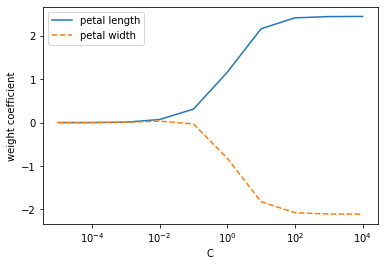

In [24]:
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

## 3.4 서포트 벡터 머신을 사용한 최대 마진 분류

퍼셉트론의 확장으로 생각  
SVM의 최적화 대상은 마진을 최대화하는 것 - 마진은 클래스를 구분하는 초평면과 이 초평면에 가장 가까운 훈련 샘플 사이의 거리로 정의, 이런 샘플을 *support vector*라고 함  

### 3.4.1 최대 마진

큰 마진의 결정 경계를 원하는 이유는 일반화 오차가 낮아지는 경향이 있기 때문  
$$\frac{\mathbb{w}^T(x_{pos}-x_{neg})}{\lVert\mathbb{w}\rVert}=\frac{2}{\lVert\mathbb{w}\rVert}$$
이 식의 좌변은 양성 측 초평면과 음성 측 초평면 사이의 거리로 해석 - margin  
목적 함수: 샘플이 정확하게 분류된다는 제약 조건 하에서 우변을 **최대화**하는 것  
$$y^{(i)}(w_0+\mathbb{w}^Tx^{(i)})\geq 1\,\forall_i$$
실제로는 quadratic programming으로 $\frac{1}{2}\lVert{\mathbb{w}}\rVert^2$를 **최소화**하는 것이 더 쉽다.  
*Reference)* The nature of statistical learning theory, A tutorial on support vector machines for pattern recognition  

### 3.4.2 슬랙 변수를 사용하여 비선형 분류 문제 다루기

슬랙 변수 ($\xi$)는 선형적으로 구분되지 않는 데이터에서 선형 제약 조건을 완화할 필요가 있기 때문에 도입  
슬랙 함수를 도입하여 **최소화**할 새 목적 함수는  
$$\frac{1}{2}\lVert{w}\rVert^2+C\left(\sum_i\xi^{(i)}\right)$$
C값이 크면 오차에 대한 비용이 커짐, 작으면 분류오차에 덜 엄격  


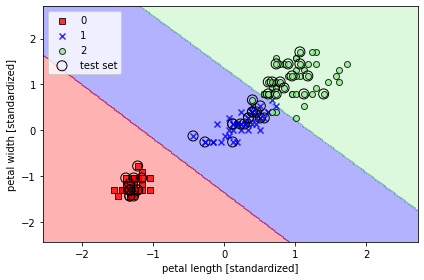

In [25]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
pltreg.plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

*Conference)* 로지스틱 회귀:  
SVM보다 이상치에 민감,  
모델이 간단하고 구현하기가 더 쉬움,  
업데이트가 용이하여 스트리밍 데이터를 다룰 때 적합  


### 3.4.3 사이킷런의 다른 구현

데이터셋이 너무 커서 컴퓨터 메모리 용량에 맞지 않는 경우  
**SGDClassifier** 클래스를 제공

In [26]:
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss="perceptron") # 퍼셉트론
lr = SGDClassifier(loss="log") # 로지스틱 회귀
svm = SGDClassifier(loss="hinge") # 서포트 벡터 머신

# 주요 매개변수: penalty (default = L2), max_iter (default = 5), n_jobs (default = 1)

## 3.5 커널 SVM을 사용하여 비선형 문제 풀기

### 3.5.1 선형적으로 구분되지 않는 데이터를 위한 커널 방법

커널 방법 (kernel method)의 기본 아이디어는 매핑함수 $\phi$를 사용하여 원본 특성의 비선형 조합을 선형적으로 구분되는 고차원 공간에 투영  
이를 통해 새로운 3차원 특성 공간으로 변환하면 클래스를 구분할 수 있다.  

고차원 공간에서 두 클래스를 구분하는 선형 초평면은 원본 특성 공간으로 되돌리면 비선형 결정 경계가 된다.

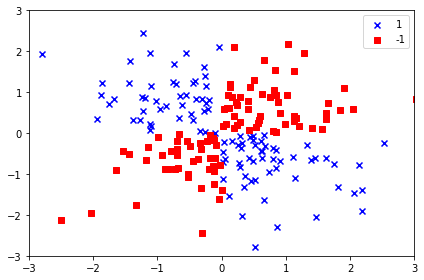

In [27]:
# XOR 형태의 간단한 데이터셋 만들기
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r', marker='s',
            label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### 3.5.2 커널 기법을 사용하여 고차원 공간에서 분할 초평면 찾기

새로운 특성을 만드는 계산 비용이 매우 비싸다 $\rightarrow$ 커널 기법 (kernel trick)  
두 포인트 사이 점곱을 계산하는 데 드는 높은 비용을 절감하기 위해 커널 함수 (kernel function)를 정의  
가장 널리 사용 되는 커널 중 하나는 **방사 기저 함수** (Radial Basis Function, RBF) 혹은 가우시안 커널로 불림  

대략적으로 말하면 커널이란 용어를 샘플 간의 **유사도 함수**로 해석할 수 있다.  
$$\mathcal{K}(x^{(i)},x^{(j)})=\exp\left(-\gamma\lVert{x^{(i)}-x^{(j)}}\rVert^2\right)$$
음수 부호가 거리 측정을 유사도 점수로 바꾸는 역할, 유사도 점수는 1 (매우 비슷한 샘플)과 0 (매우 다른 샘플) 사이 범위를 가짐  



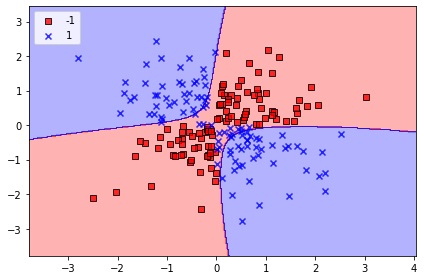

In [28]:
# 비선형결정경계 그리기
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
pltreg.plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

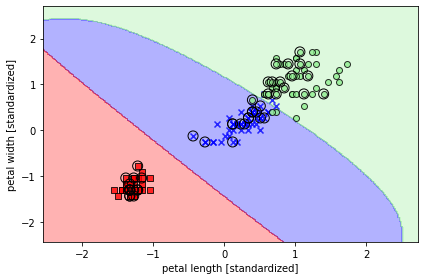

In [29]:
# gamma란 무엇일까?
# gamma를 비교적 작게 설정 = 부드러운 경계
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
pltreg.plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                             test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.tight_layout()
plt.show()

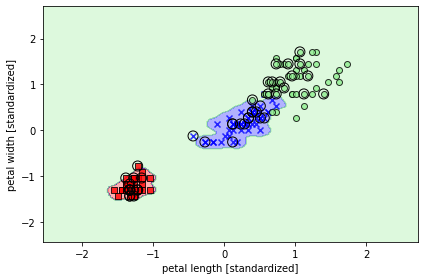

In [31]:
# gamma를 크게 설정 = 훈련 데이터에 완전 딱 맞게 분류
# 너무 크게 설정하면 overfitting
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
pltreg.plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                             test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.tight_layout()
plt.show()

## 3.6 결정 트리 학습

### 3.6.1 정보 이득 최대화: 자원을 최대로 활용

가장 정보가 풍부한 특성으로 노드를 나누기 위해 트리 알고리즘으로 최적화할 목적 함수를 정의  
이 목적 함수는 각 분할에서 정보 이득 (information gain, IG)을 최대화,  
$$IG(D_p, f)=I(D_p)-\sum_{j=1}^m\frac{N_j}{N_p}I(D_j)$$
$f$는 분할에 사용할 특성  
$D_p$와 $D_j$는 부모와 $j$번째 자식 노드의 데이터셋  
$I$는 불순도 (impurity) 지표  
$N_p$는 부모 노드에 있는 전체 샘플 개수, $N_j$는 $j$번째 자식 노드에 있는 샘플 개수  
그러므로, IG는 단순히 부모 노드의 불순도와 자식 노드의 불순도 합의 차이임.  
대부분의 라이브러리는 이진 트리를 사용하므로 왼쪽/오른쪽 자식 노드를 가지므로 위의 식을 바꾸면,
$$IG(D_p, f)=I(D_p)-\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$$

널리 사용되는 세 개의 불순도 지표 또는 분할 조건은 **지니 불순도 (Gini impurity, $I_G$)**, **엔트로피 (entropy, $I_H$)**, **분류 오차 (classification error, $I_E$)**  

* 엔트로피의 정의:  
$$I_H(t)=-\sum_{i=1}^cp(i\vert t)\log_2p(i\vert t)$$
클래스 분포가 균등하면 엔트로피는 최대가 됨  
트리의 상호 의존 정보를 최대화하는 것으로 이해  

* 지니 불순도:  
잘못 분류될 확률을 최소화하기 위한 기준으로 이해
$$I_G(t)=\sum_{i=1}^cp(i\vert t)(1-p(i\vert t))=1-\sum_{i=1}^cp(i\vert t)^2$$
보통 불순도 조건을 바꾸어 트리를 평가하기 보다 가지치기 수준을 바꾸면서 튜닝하는 것이 훨씬 낫다.  

* 분류 오차:  
$$I_E=1-\max\left\{p(i\vert t)\right\}$$
가지치기에는 좋은 기준이지만 결정 트리 구성에는 권장하지 않는다.  
